In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from statsmodels.stats.power import TTestIndPower

p = 0.05
pi0 = 0.5
beta = 0.8

minFPR = (p*pi0)/(p*pi0+(1-beta)*(1-pi0))
print(f'minimum FPR = {minFPR:.1f}')

minimum FPR = 0.2


# Example 1 (Button et al 2013)
Below, we will write some code to play with the analysis shown in Fig. 1

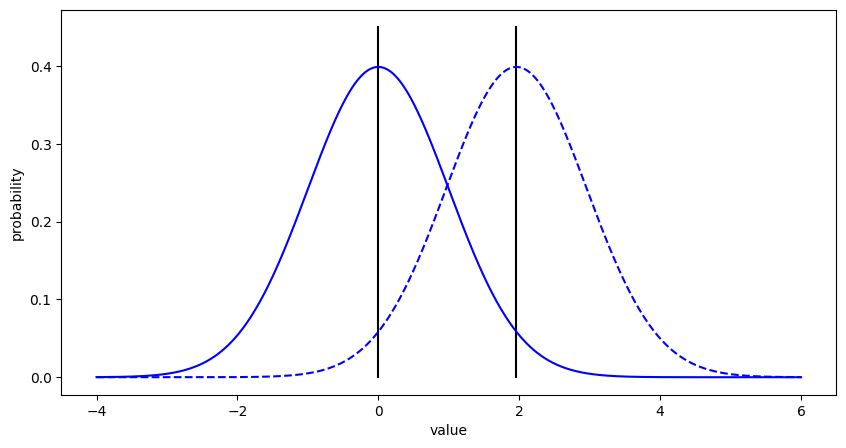

49775 positive outcomes out   of 100000 experiments (49.78 pct)


/var/folders/5w/lmyt51rs5qn2jcjnlw11cxr00000gq/T/ipykernel_81942/2428003094.py:44: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  normalizer          = np.trapz(counts_all, dx=bin_size)


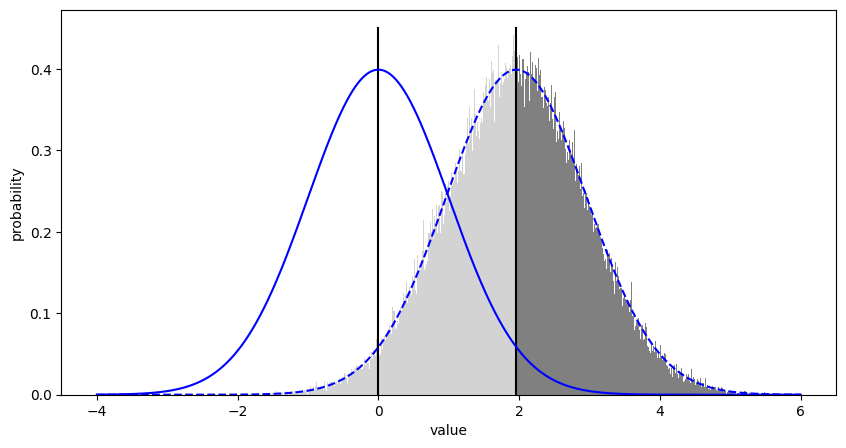

In [3]:
# Assume that an original study identified an effect size, 
#   representing the difference in the mean value of a test distribution 
#   versus a null distribution, divided by their common standard deviation 
#   (i.e., the z-score of their difference), at exactly p=0.05. 
#   Remember:
#   these are distributions of mean values, so the standard deviations 
#   of these distributions represent standard errors of the mean. For a 
#   two-tailed test, this p-value implies that 0.975 of the area of the 
#   null distribtion is less than the effect size:
effect_size = st.norm.ppf(0.975)

# We can now reproduce the first panel:
plt.figure(figsize=(10, 5))
mu_0 = 0
sem = 1      # make it easy by assuming sem=1
mu_1 = effect_size*sem
bin_size = 0.01
x_axis = np.arange(-4, 6+bin_size, bin_size)
x_edges = np.arange(x_axis[0]-bin_size/2, x_axis[-1]+bin_size, bin_size)
plt.plot([mu_0, mu_0], [0, 0.45], 'k-')
plt.plot([mu_1, mu_1], [0, 0.45], 'k-')
plt.plot(x_axis, st.norm.pdf(x_axis, mu_0, sem), 'b-')
plt.plot(x_axis, st.norm.pdf(x_axis, mu_1, sem), 'b--')
plt.xlabel('value')
plt.ylabel('probability')
plt.show()

# Now what happens when we try to replicate the result under the exact 
#   same conditions? Let's simulate N experiments:
N = 100000

# In each simulated experiment, we end up with a mean value that comes 
#   from the experimental distribution, and we only reject the Null 
#   hypothesis if the value is greater than or equal to the previous effect size:
outcomes = np.random.normal(mu_1, sem, N)
outcome_is_positive = outcomes >= effect_size
print(f'{np.count_nonzero(outcome_is_positive)} positive outcomes out \
  of {N} experiments ({np.count_nonzero(outcome_is_positive)/N*100:.2f} pct)')

# We can plot these results as a normalized histogram
counts_no_effect, _ = np.histogram(outcomes[np.logical_not(outcome_is_positive)], bins=x_edges)
counts_effect, _    = np.histogram(outcomes[outcome_is_positive], bins=x_edges)
counts_all, _       = np.histogram(outcomes, bins=x_edges)
normalizer          = np.trapz(counts_all, dx=bin_size)

# Plot it
plt.figure(figsize=(10, 5))
plt.bar(x_axis, counts_no_effect/normalizer, width=0.01, color='lightgray')
plt.bar(x_axis, counts_effect/normalizer, width=0.01, color='gray')
plt.plot([mu_0, mu_0], [0, 0.45], 'k-')
plt.plot([mu_1, mu_1], [0, 0.45], 'k-')
plt.plot(x_axis, st.norm.pdf(x_axis, mu_0, sem), 'b-')
plt.plot(x_axis, st.norm.pdf(x_axis, mu_1, sem), 'b--')
plt.xlabel('value')
plt.ylabel('probability')
plt.show()

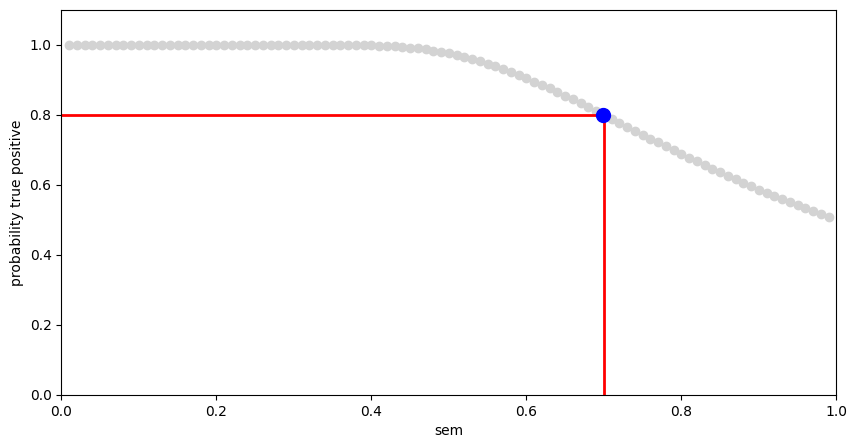

In [4]:
# We can increase the power by increasing the signal-to-noise ratio (SNR) of 
#   our sample, via a reduction in sem and assuming the same mean effect size. 
#   The figure in the paper is confusing, because increasing SNR would narrow 
#   *both* distributions (because we assume that the two hypotheses differ only 
#   by their mean value, not the STD of the distributions). It is the change in 
#   both distributions that explains why you would be less likely to reject the 
#   Null hypothesis for the same effect size under these conditions.
#
# Also note that sem depends on both the number of samples (N) and the STD of 
#   the sampled distribution, so we need to define N or STD to be able to 
#   express sem in terms of the other of those two values.

# We can use a power analysis to find the new sem. The key point is that a 
#   power analysis describes a relationship between the effect size and the 
#   power -- so we can define a particular power to compute the effect size. 
#   In this case, this computation is equivalent to doing a z test with one 
#   sample and a power of 80%, which can be computed as follows (which is 
#   basically computing: what is the mean of a standard normal distribution 
#   that has 80% of its mass >= the cutoff for the null distribution at z=0.975?)
power = 0.8
new_effect_size = st.norm.ppf(0.975) - st.norm.ppf(1-power)

# This effect size is again the z-score, given the same mean difference 
#   as above and the new sem -- so we can use it to compute the new sem:
old_effect_size = st.norm.ppf(0.975)
old_sem = 1
mu_0 = 0
mu_1 = effect_size*old_sem
new_sem = (mu_1-mu_0)/new_effect_size

# To show that this is the case, let's try a bunch of sems and find the 
#   value that corresponds to when 80% of the effect distribution is >= the 
#   p=0.05 cutoff for the null distribution

# Try a bunch of sems, smaller than before (i.e., <1)
sems = np.arange(0.01, 1, 0.01)
vals = np.zeros(np.size(sems))

# Loop through them
for idx, val in enumerate(sems):
   
   # The probability of not rejecting the null hypothesis when the null 
   #  hypothesis is false is the mass of the effect distribution, which still 
   #  has a mean value of effectSize but now has the given sem, that is to the 
   #  right of the new cutoff
   new_cutoff = st.norm.ppf(0.975, mu_0, val)
   vals[idx] = 1 - st.norm.cdf(new_cutoff, effect_size, val) 

# Plot it
plt.figure(figsize=(10, 5))
plt.plot(sems, vals, 'o', color='lightgray')
val_indices = np.flatnonzero(vals<=0.8)
new_sem2 = sems[val_indices[0]]
plt.plot([new_sem2, new_sem2], [0, 0.8], 'r-', linewidth=2)
plt.plot([0, new_sem2], [0.8, 0.8], 'r-', linewidth=2)
plt.plot(new_sem, 0.8, 'bo', markerfacecolor='b', markersize=10)
plt.xlabel('sem')
plt.ylabel('probability true positive')
plt.axis([0, 1, 0, 1.1])
plt.show()

79942 positive outcomes out of   100000 experiments (79.94 pct)


/var/folders/5w/lmyt51rs5qn2jcjnlw11cxr00000gq/T/ipykernel_81942/3885056187.py:23: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  normalizer          = np.trapz(counts_all, dx=bin_size)


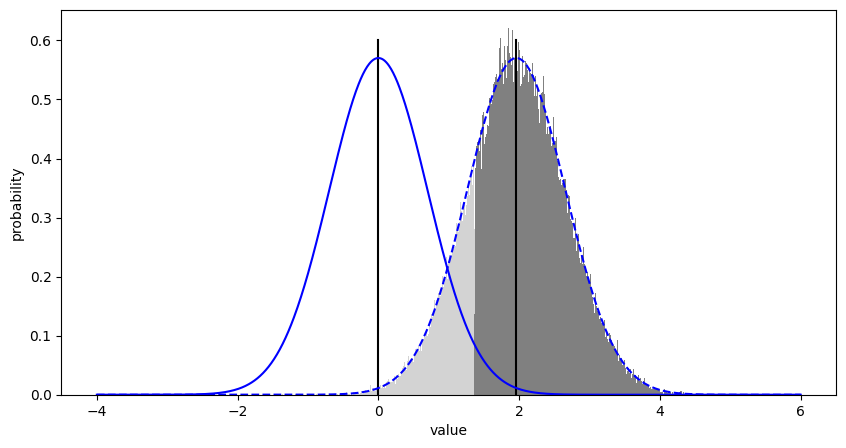

In [5]:
# Now do the simulated experiments as above, but with the new distributions
N = 100000
power = 0.8
new_effect_size = st.norm.ppf(0.975) - st.norm.ppf(1-power)
old_sem = 1
mu_0 = 0
mu_1 = effect_size*old_sem
new_sem = (mu_1-mu_0)/new_effect_size

bin_size = 0.01
x_axis = np.arange(-4, 6+bin_size, bin_size)
x_edges = np.arange(x_axis[0]-bin_size/2, x_axis[-1]+bin_size, bin_size)

outcomes = np.random.normal(mu_1, new_sem, N)
outcome_is_positive = outcomes >= st.norm.ppf(0.975, mu_0, new_sem)
print(f'{np.count_nonzero(outcome_is_positive)} positive outcomes out of \
  {N} experiments ({np.count_nonzero(outcome_is_positive)/N*100:.2f} pct)')

# We can plot these results as a normalized histogram
counts_no_effect, _ = np.histogram(outcomes[np.logical_not(outcome_is_positive)], bins=x_edges)
counts_effect, _    = np.histogram(outcomes[outcome_is_positive], bins=x_edges)
counts_all, _       = np.histogram(outcomes, bins=x_edges)
normalizer          = np.trapz(counts_all, dx=bin_size)

# Plot it
plt.figure(figsize=(10, 5))
plt.bar(x_axis, counts_no_effect/normalizer, width=0.01, color='lightgray')
plt.bar(x_axis, counts_effect/normalizer, width=0.01, color='gray')
plt.plot([mu_0, mu_0], [0, 0.6], 'k-')
plt.plot([mu_1, mu_1], [0, 0.6], 'k-')
plt.plot(x_axis, st.norm.pdf(x_axis, mu_0, new_sem), 'b-')
plt.plot(x_axis, st.norm.pdf(x_axis, mu_1, new_sem), 'b--')
plt.xlabel('value')
plt.ylabel('probability')
plt.show()

# Example 2
Do a post-hoc power analysis to determine the number of data samples needed to achieve 80% power for a series of possible effect sizes.

*Notes and tips:*
1) Given that the data have already been collected, note that this is technically a "post-hoc" power analysis and is for demonstration purposes only. Normally these analyses must be done before collecting data.
2) Assume that a "data sample" is simply the non-parametric correlation coefficient between pupil diameter and LC activty measured in a given session.
3) Thus, to obtain a null distribution of these data samples, compute the correlation coefficients on simulated data that are independently generated from Poisson (for LC spiking data) and Gaussian (for pupil data)distributions.
4) Then plot n (number of data samples, corresponding to correlation coefficients measured in a single experimental session) needed for 80% power as a function of effect sizes.
5) To compute power, you can use TTestIndPower in Python, or sampsizepwr in Matlab

Into ChatGPT:
"can you please write python code to simulate data in which each "data sample" is simply the non-parametric correlation coefficient between variable A and variable B, then plot n (number of data samples, corresponding to correlation coefficients measured in a single experimental session) needed for 80% power as a function of effect sizes. To compute power, use TTestIndPower in Python"

Response:
Got it 👍 — you want to simulate data where each “data sample” is a non-parametric correlation coefficient (like Spearman’s ρ) between two variables 
𝐴
A and 
𝐵
B, and then compute how many such samples (per experimental session) are required to achieve 80% power for a range of effect sizes.

Since TTestIndPower in statsmodels is designed for two-sample t-tests, we’ll treat each correlation coefficient (from one session) as a single data point. Then, we can compute the sample size needed for detecting different effect sizes.

Here’s a Python script that does exactly that:

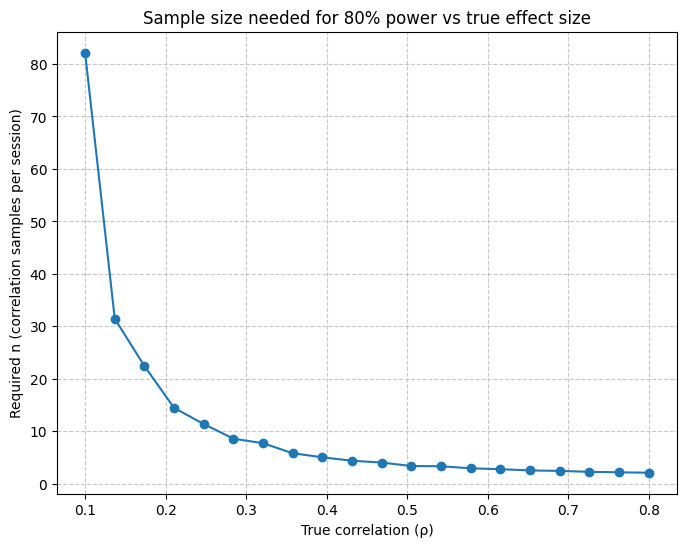

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from statsmodels.stats.power import TTestIndPower

# --- Parameters ---
n_sessions = 1000   # number of simulated sessions per effect size
n_obs = 30          # number of paired observations per session (to compute a correlation)
effect_sizes = np.linspace(0.1, 0.8, 20)  # range of true correlations (ρ)
alpha = 0.05
power_target = 0.8

# --- Initialize power analysis tool ---
analysis = TTestIndPower()

# --- Function to simulate a correlation coefficient ---
def simulate_corr(true_r, n_obs):
    """
    Simulate correlation between A and B given a true correlation (true_r).
    We generate B correlated with A, then compute Spearman correlation.
    """
    A = np.random.normal(0, 1, n_obs)
    B = true_r * A + np.sqrt(1 - true_r**2) * np.random.normal(0, 1, n_obs)
    rho, _ = spearmanr(A, B)
    return rho

# --- Collect required sample sizes for each effect size ---
required_ns = []

for true_r in effect_sizes:
    # Simulate session-level correlation coefficients
    corrs = np.array([simulate_corr(true_r, n_obs) for _ in range(n_sessions)])
    
    # Fisher z-transform to approximate normality
    z_corrs = np.arctanh(corrs)  # z = atanh(r)
    
    # Effect size for t-test ~ mean difference / std
    cohens_d = np.mean(z_corrs) / np.std(z_corrs, ddof=1)
    
    # Ensure it's a float
    cohens_d = float(cohens_d)
    
    # Solve for required sample size
    n_required = analysis.solve_power(effect_size=abs(cohens_d),
                                      power=power_target,
                                      alpha=alpha)
    required_ns.append(n_required)

# --- Plot results ---
plt.figure(figsize=(8,6))
plt.plot(effect_sizes, required_ns, marker="o")
plt.xlabel("True correlation (ρ)")
plt.ylabel("Required n (correlation samples per session)")
plt.title("Sample size needed for 80% power vs true effect size")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

